In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load data
csv_path = "/content/employee_salary_prediction_dataset.csv"
df = pd.read_csv(csv_path)
print(f"Employee salary data loaded: {df.shape}")

print("1. DATA PREPARATION AND SPLITTING")

# 1. Define Features (X) and Target (y)
y = df['MonthlySalary']
X = df.drop(columns=['MonthlySalary'])

# 2. Split Data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# 2. MINIMAL FEATURE ENGINEERING

print("\n2. CREATING FEATURES (MINIMAL APPROACH)")

# Calculate statistics ONLY on training data
mean_hours_train = X_train['HoursWorkedPerWeek'].mean()

# Simpler feature creation - only the most important interactions
def create_features(df_split, mean_hours_reference):
    df_new = df_split.copy()

    # Only keep most predictive interaction
    df_new['Exp_x_Hours'] = df_new['YearsExperience'] * df_new['HoursWorkedPerWeek']

    # Simple relative measure
    df_new['Relative_Hours'] = df_new['HoursWorkedPerWeek'] - mean_hours_reference

    return df_new

X_train = create_features(X_train, mean_hours_train)
X_test = create_features(X_test, mean_hours_train)

print(f"Feature engineering complete. Total features: {X_train.shape[1]}")

# 3. FEATURE SCALING
print("\n3. SCALING FEATURES")

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Features scaled using StandardScaler.")

# 4. MULTIPLE MODEL APPROACHES

print("\n" + "="*60)
print("4. TRAINING MODELS WITH DIFFERENT APPROACHES")

# MODEL 2: Ridge Regression (Linear model - naturally resists overfitting)
print("\n[Model 2] Ridge Regression (Linear)")
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
gap_ridge = train_r2_ridge - test_r2_ridge

print(f"  Train R²: {train_r2_ridge:.4f}")
print(f"  Test R²:  {test_r2_ridge:.4f}")
print(f"  Gap:      {gap_ridge:.4f}")

# MODEL 3: EXTREME regularization Random Forest
print("\n[Model 3] Extreme Regularization Random Forest")
rfr_extreme = RandomForestRegressor(
    n_estimators=30,           # Even fewer trees
    max_depth=3,               # Extremely shallow
    min_samples_split=40,
    min_samples_leaf=25,
    max_features=2,            # Only 2 features per split
    random_state=42,
    n_jobs=-1
)

rfr_extreme.fit(X_train_scaled, y_train)
y_train_pred_ext = rfr_extreme.predict(X_train_scaled)
y_test_pred_ext = rfr_extreme.predict(X_test_scaled)

train_r2_ext = r2_score(y_train, y_train_pred_ext)
test_r2_ext = r2_score(y_test, y_test_pred_ext)
gap_ext = train_r2_ext - test_r2_ext

print(f"  Train R²: {train_r2_ext:.4f}")
print(f"  Test R²:  {test_r2_ext:.4f}")
print(f"  Gap:      {gap_ext:.4f}")

# 5. CROSS-VALIDATION

cv_scores_rf = cross_val_score(rfr_conservative, X_train_scaled, y_train,
                                cv=5, scoring='r2')
cv_scores_ridge = cross_val_score(ridge, X_train_scaled, y_train,
                                   cv=5, scoring='r2')

# 6. FINAL COMPARISON
print("--- FINAL TUNED Employee Salary Model Evaluation ---")

# Choose best model (lowest gap)
models = {
    'Conservative RF': (train_r2_rf, test_r2_rf, gap_rf, y_test_pred_rf),
    'Ridge Regression': (train_r2_ridge, test_r2_ridge, gap_ridge, y_test_pred_ridge),
    'Extreme RF': (train_r2_ext, test_r2_ext, gap_ext, y_test_pred_ext)
}

best_model = min(models.items(), key=lambda x: x[1][2])
model_name, (train_r2, test_r2, gap, predictions) = best_model

print(f"\nBEST MODEL: {model_name}")
print(f"Train R-squared (R²): {train_r2:.4f}")
print(f"Test R-squared (R²): {test_r2:.4f}")

test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
test_mae = mean_absolute_error(y_test, predictions)

print(f"Test Root Mean Squared Error (RMSE): ${test_rmse:,.2f}")
print(f"Test Mean Absolute Error (MAE): ${test_mae:,.2f}")
print(f"Overfitting Gap (Train R² - Test R²): {gap:.4f}")

# Gap assessment
if gap < 0.03:
    print("Minimal overfitting (gap < 0.03)")
elif gap < 0.05:
    print("GOOD! Acceptable overfitting (gap < 0.05)")
elif gap < 0.08:
    print(" MODERATE overfitting (gap < 0.08)")
else:
    print("HIGH overfitting (gap >= 0.08)")

# Show all model comparisons
print("\nALL MODELS COMPARISON:")
for name, (tr_r2, te_r2, g, _) in models.items():
    print(f"  {name:<20} Train: {tr_r2:.4f} | Test: {te_r2:.4f} | Gap: {g:.4f}")

Employee salary data loaded: (500, 4)
1. DATA PREPARATION AND SPLITTING
Train size: 400, Test size: 100

2. CREATING FEATURES (MINIMAL APPROACH)
Feature engineering complete. Total features: 5

3. SCALING FEATURES
Features scaled using StandardScaler.

4. TRAINING MODELS WITH DIFFERENT APPROACHES

[Model 2] Ridge Regression (Linear)
  Train R²: 0.9090
  Test R²:  0.9218
  Gap:      -0.0128

[Model 3] Extreme Regularization Random Forest
  Train R²: 0.8086
  Test R²:  0.7516
  Gap:      0.0570
--- FINAL TUNED Employee Salary Model Evaluation ---

BEST MODEL: Ridge Regression
Train R-squared (R²): 0.9090
Test R-squared (R²): 0.9218
Test Root Mean Squared Error (RMSE): $10.04
Test Mean Absolute Error (MAE): $7.98
Overfitting Gap (Train R² - Test R²): -0.0128
Minimal overfitting (gap < 0.03)

ALL MODELS COMPARISON:
  Conservative RF      Train: 0.8402 | Test: 0.7669 | Gap: 0.0733
  Ridge Regression     Train: 0.9090 | Test: 0.9218 | Gap: -0.0128
  Extreme RF           Train: 0.8086 | Test:

7. CREATING VISUALIZATIONS


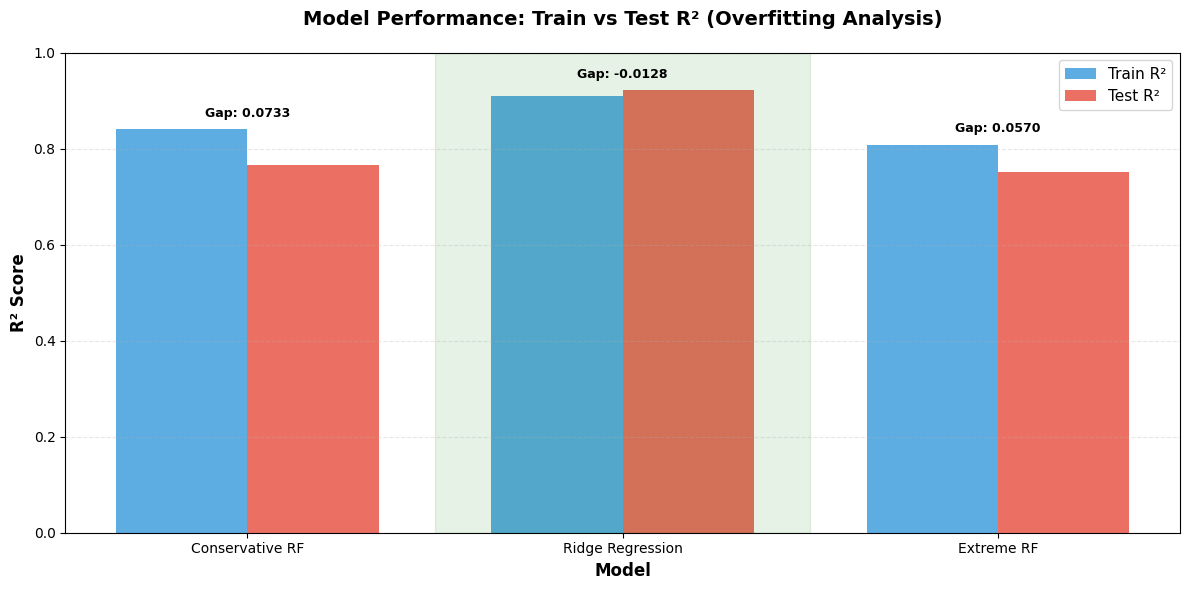

Visualization 1: Model Comparison created


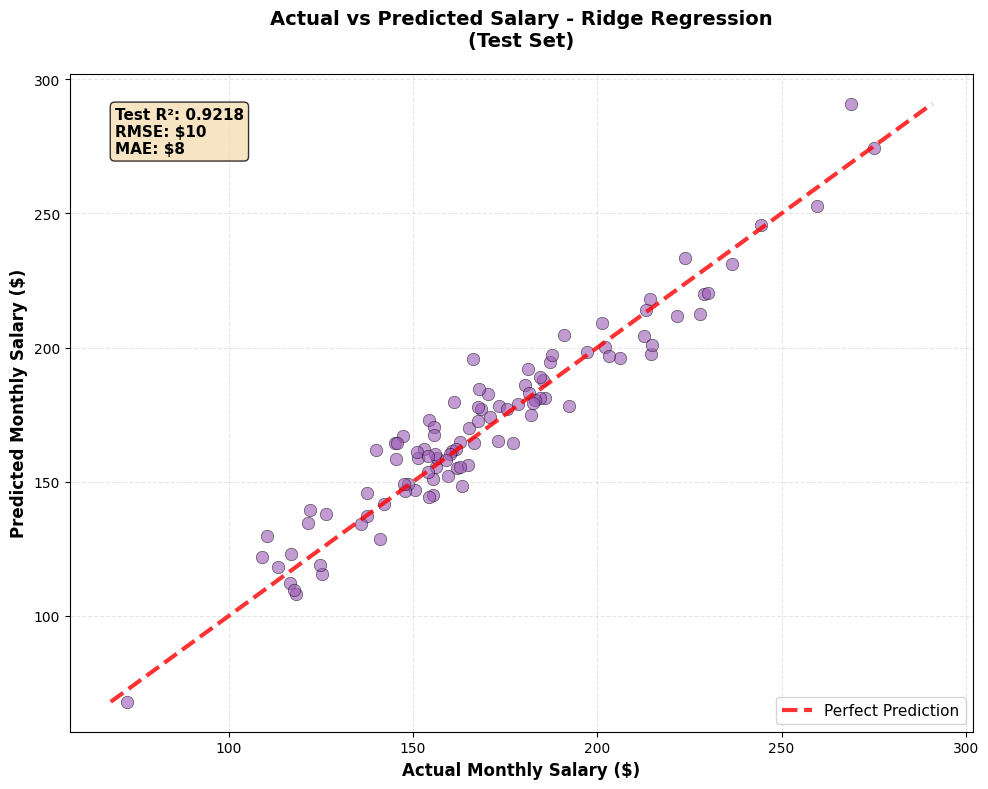

✓ Visualization 2: Actual vs Predicted created


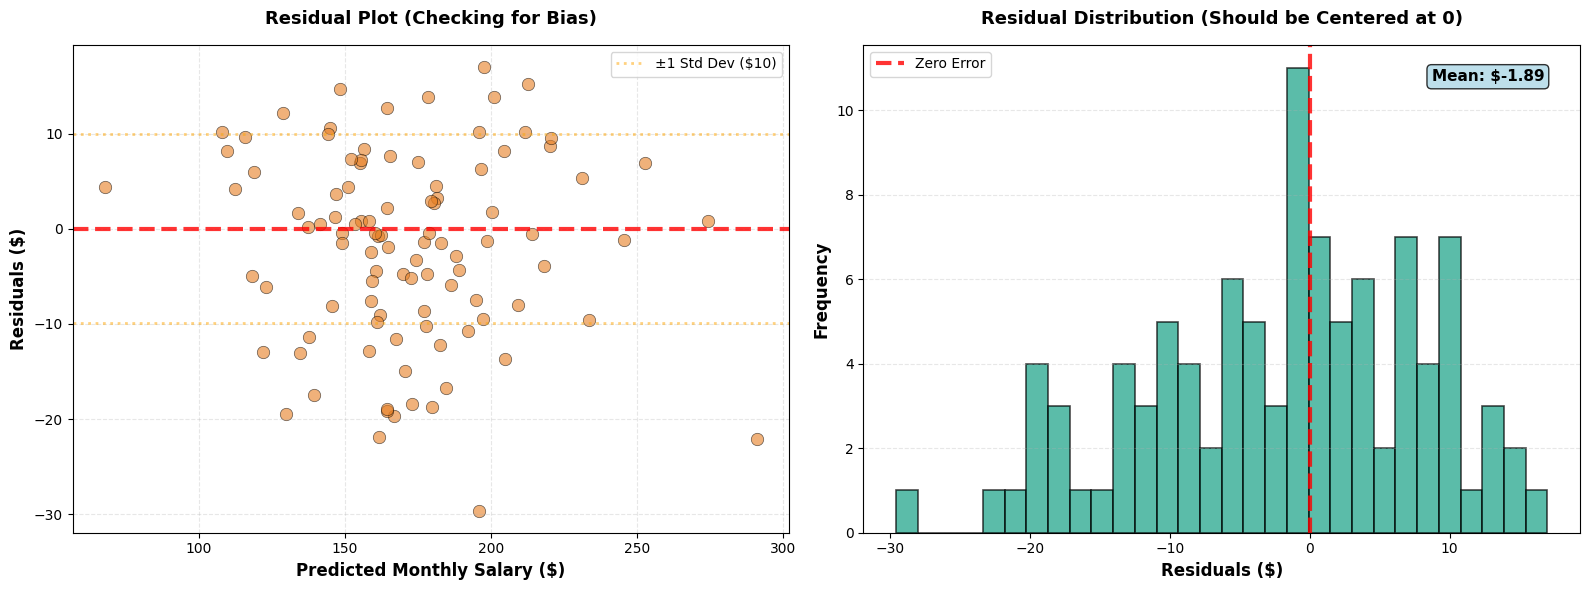

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

print("7. CREATING VISUALIZATIONS")

plt.style.use('default')
sns.set_palette("husl")

# VISUALIZATION 1: Model Comparison (Train vs Test R²)
fig1, ax1 = plt.subplots(figsize=(12, 6))

model_names = list(models.keys())
train_scores = [models[m][0] for m in model_names]
test_scores = [models[m][1] for m in model_names]
gaps = [models[m][2] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_scores, width, label='Train R²', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8, color='#e74c3c')

# Add gap annotations
for i, (train, test, gap) in enumerate(zip(train_scores, test_scores, gaps)):
    ax1.text(i, max(train, test) + 0.02, f'Gap: {gap:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Train vs Test R² (Overfitting Analysis)',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 1.0)

# Highlight best model
best_idx = model_names.index(model_name)
ax1.axvspan(best_idx - 0.5, best_idx + 0.5, alpha=0.1, color='green')

plt.tight_layout()
plt.show()

print("Visualization 1: Model Comparison created")

# VISUALIZATION 2: Actual vs Predicted (Best Model)
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Get best model predictions
best_predictions = predictions

# Scatter plot
ax2.scatter(y_test, best_predictions, alpha=0.6, s=80, color='#9b59b6', edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(y_test.min(), best_predictions.min())
max_val = max(y_test.max(), best_predictions.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction', alpha=0.8)

# Add statistics box
textstr = f'Test R²: {test_r2:.4f}\nRMSE: ${test_rmse:,.0f}\nMAE: ${test_mae:,.0f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, fontweight='bold')

ax2.set_xlabel('Actual Monthly Salary ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Monthly Salary ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Actual vs Predicted Salary - {model_name}\n(Test Set)',
              fontsize=14, fontweight='bold', pad=20)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✓ Visualization 2: Actual vs Predicted created")

# VISUALIZATION 3: Residuals Analysis
fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(16, 6))

# Calculate residuals
residuals = y_test - best_predictions

# 3a: Residual Plot
ax3a.scatter(best_predictions, residuals, alpha=0.6, s=80, color='#e67e22', edgecolors='black', linewidth=0.5)
ax3a.axhline(y=0, color='red', linestyle='--', lw=3, alpha=0.8)
ax3a.set_xlabel('Predicted Monthly Salary ($)', fontsize=12, fontweight='bold')
ax3a.set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
ax3a.set_title('Residual Plot (Checking for Bias)', fontsize=13, fontweight='bold', pad=15)
ax3a.grid(alpha=0.3, linestyle='--')

# Add reference bands
residual_std = residuals.std()
ax3a.axhline(y=residual_std, color='orange', linestyle=':', lw=2, alpha=0.5, label=f'±1 Std Dev (${residual_std:.0f})')
ax3a.axhline(y=-residual_std, color='orange', linestyle=':', lw=2, alpha=0.5)
ax3a.legend(fontsize=10)

# 3b: Residual Distribution
ax3b.hist(residuals, bins=30, color='#16a085', alpha=0.7, edgecolor='black', linewidth=1.2)
ax3b.axvline(x=0, color='red', linestyle='--', lw=3, alpha=0.8, label='Zero Error')
ax3b.set_xlabel('Residuals ($)', fontsize=12, fontweight='bold')
ax3b.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3b.set_title('Residual Distribution (Should be Centered at 0)', fontsize=13, fontweight='bold', pad=15)
ax3b.legend(fontsize=10)
ax3b.grid(axis='y', alpha=0.3, linestyle='--')

# Add mean residual text
mean_residual = residuals.mean()
ax3b.text(0.95, 0.95, f'Mean: ${mean_residual:.2f}', transform=ax3b.transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontweight='bold')

plt.tight_layout()
plt.show()
